# DDQN

In [1]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count
from time import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import pandas as pd

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
device_name = "cpu"

if False:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cpu


## Process data

In [3]:
import sys
sys.path.append("/Users/toshi/Documents/school/machine-learning")
# sys.path.append(r"C:\Users\takat\PycharmProjects\machine-learning")
# sys.path.append("/Users/toshi_pro/Documents/github-sub/machine-learning")
import flowdata
import flowenv

raw_data_train, raw_data_test = flowdata.flow_data.using_data()

# train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
train_env = gym.make("flowenv/Flow-v1", data=raw_data_train)
# test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)
test_env = gym.make("flowenv/Flow-v1", data=raw_data_test)

## Memory

In [4]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Plot rewards

In [5]:
# %matplotlib notebook
def plot_rewards(rewards: list, show_result=False, save_graph=False):
    plt.figure(figsize=(16,4))
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    means = [rewards[0]]
    for i in range(1, len(rewards)):
        means.append(np.mean(rewards[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("Ratio")
    # plt.plot(rewards)
    plt.plot(means, color="red")
    plt.grid()

    if save_graph:
        plt.savefig("ddqn_no3.png")
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Plot Metrics

In [6]:
def plot_metrics(metrics_dict: dict, show_result=False, save_graph=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
    if save_graph:
        plt.savefig("ddqn_no3.png")


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr

## Network

In [7]:
class DQNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Constants

In [8]:
UPDATE_TARGET_STEPS = 200
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-5

## Variables

In [9]:
num_episodes = 5000
n_actions = train_env.action_space.n
n_inputs = train_env.observation_space.shape[0]

state, info = train_env.reset()

policy_net = DQNetwork(n_inputs, n_actions).to(device)
target_net = DQNetwork(n_inputs, n_actions).to(device)
# target_net.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
# policy_net.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
steps_done = 0

memory = ReplayMemory(10000)
episode_rewards = []
episode_precision = []

## Functions

In [10]:
def select_action(state: torch.Tensor):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # print(f"true or false: {sample > eps_threshold}")
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_actions = policy_net(non_final_next_states).max(1).indices.unsqueeze(1)
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_actions).squeeze(1)

    expected_state_action_values = reward_batch + GAMMA * next_state_values

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    utils.clip_grad_value_(policy_net.parameters(), 10000)
    optimizer.step()

## Main loop

In [11]:
num_episodes = 10000

<Figure size 640x480 with 0 Axes>

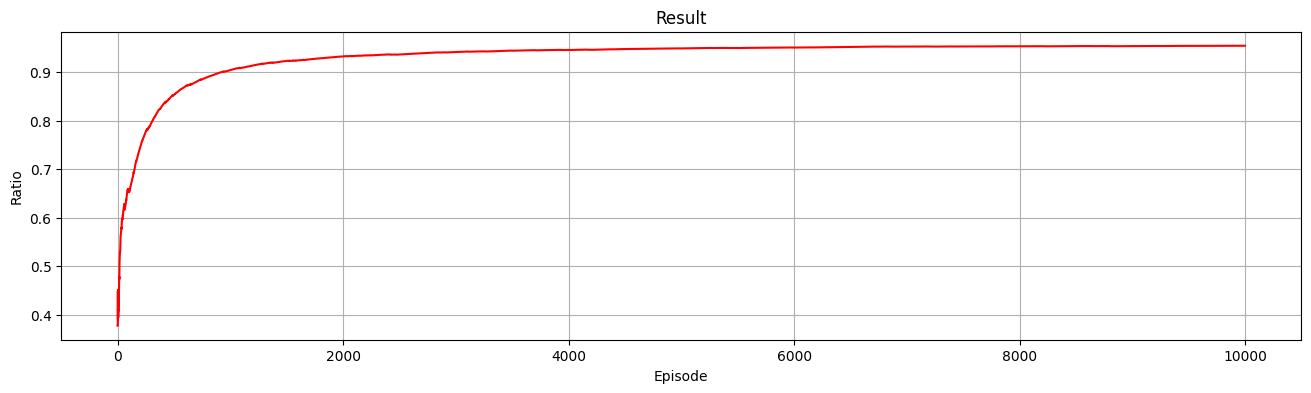

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
for i_episode in range(num_episodes):
    random.seed(i_episode)
    # Initialize the environment and state
    sum_reward = 0
    confusion_matrix = np.zeros((2,2), dtype=int)


    initial_state, info = train_env.reset()
    state = torch.tensor(initial_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        # select action
        action = select_action(state)

        # calculate next state
        raw_next_state, reward, terminated, truncated, info = train_env.step(action.item())
        row_column_index = info["confusion_position"]
        confusion_matrix[row_column_index[0], row_column_index[1]] += 1

        # to tensor
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        # store the transition in memory
        memory.push(state, action, next_state, reward)
        sum_reward += reward.item() if reward.item() == 1 else 0

        # move to the next state
        state = next_state

        # optimize the model
        optimize_model()

        # update the target network
        if steps_done % UPDATE_TARGET_STEPS == 0:
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in target_net_state_dict:
                target_net_state_dict[key] = TAU * policy_net_state_dict[key] + (1 - TAU) * target_net_state_dict[key]
            target_net.load_state_dict(target_net_state_dict)

        if terminated:
            episode_rewards.append(sum_reward / (t + 1))
            break

    # do after the episode
    # episode_rewards.append(sum_reward)
    base = confusion_matrix[0, 0] + confusion_matrix[1, 0]
    episode_precision.append(
        confusion_matrix[0,0] / base if base != 0 else 0
    )

    if i_episode > 0 and i_episode % 10 == 0:
        plot_rewards(episode_precision)

# complete the episode
plot_rewards(episode_precision, show_result=True)
torch.save(policy_net.state_dict(), "ddqn_re_no3.pth")  # save the model

train_env.close()

## Test the model

In [13]:
steps_done

1024069

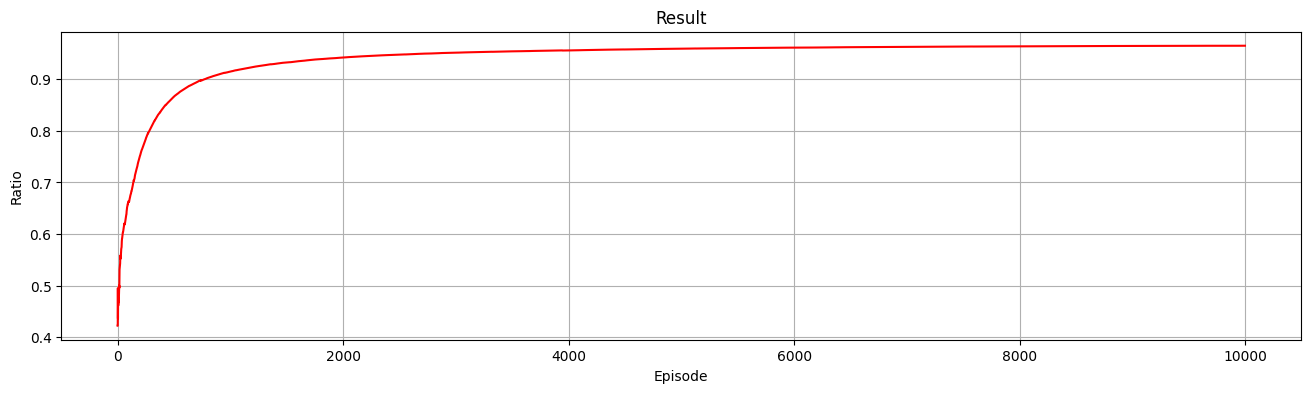

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
torch.save(policy_net.state_dict(), "ddqn_no3.pth")  # save the model
plot_rewards(episode_rewards, show_result=True, save_graph=True)

8264 793 350 36
8293 795 351 36
8342 800 353 37
8373 804 354 37
8389 807 354 37
8543 823 363 37
8767 841 369 38
8788 841 370 38
8840 847 374 38
[0, 1] = [1221, 8878]


<Figure size 640x480 with 0 Axes>

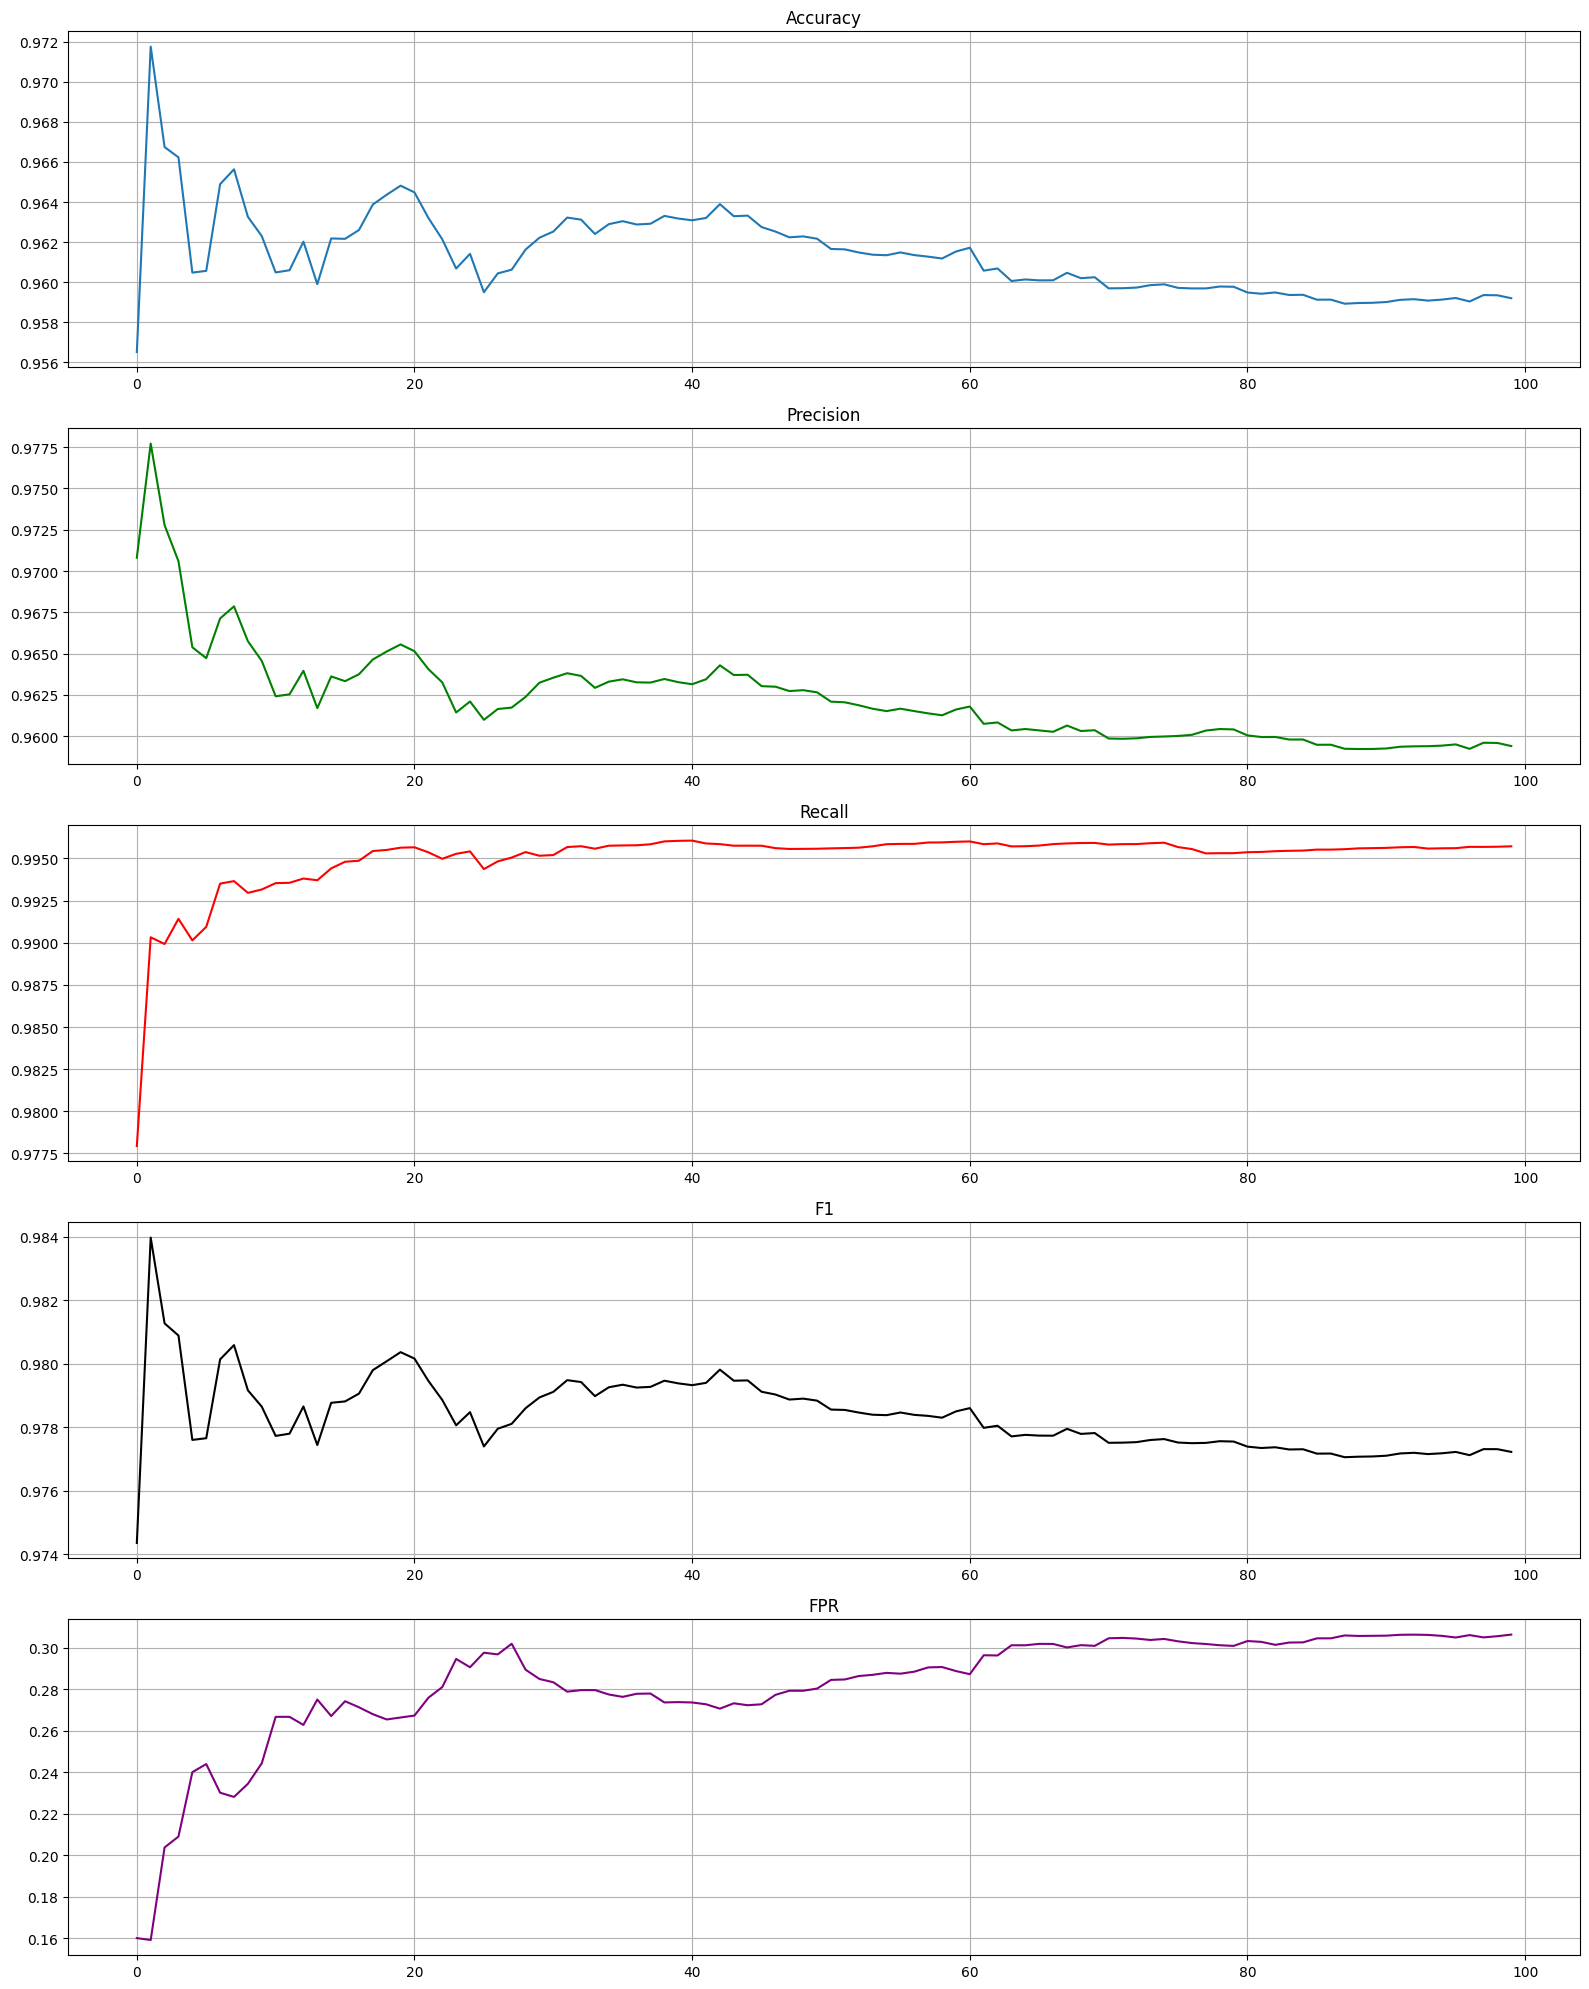

<Figure size 640x480 with 0 Axes>

 accuracy: 0.9592038815724329
precision: 0.959409594095941
  recall : 0.9957197567019599
    f1   : 0.9772275038691135
   fpr   : 0.3063063063063063


<Figure size 640x480 with 0 Axes>

In [ ]:
MODEL_PATH = "ddqn_re_no3.pth"

# load the model
trained_network = DQNetwork(n_inputs, n_actions).to(device)
trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
trained_network.eval()

# test the model

confusion_array = np.zeros((2, 2), dtype=np.int32)
metrics_dictionary = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}
result = [0, 0]
for i_loop in range(100):
    test_raw_state, _ = test_env.reset()
    test_state = torch.tensor(test_raw_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        with torch.no_grad():
            test_action = trained_network(test_state).max(1).indices.view(1, 1)

        result[test_action] += 1
        test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

        # calculate confusion matrix
        raw = 0 if test_reward == 1 else 1

        # test_info = (row, column) means confusion matrix index
        index = test_info["confusion_position"]
        confusion_array[index[0], index[1]] += 1

        if test_terminated:
            break

        # make next state tensor and update state
        test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)

    # calculate metrics
    tp = confusion_array[1, 1]
    tn = confusion_array[0, 0]
    fp = confusion_array[1, 0]
    fn = confusion_array[0, 1]
    print(tp, tn, fp, fn)

    accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
    metrics_dictionary["accuracy"].append(accuracy)
    metrics_dictionary["precision"].append(precision)
    metrics_dictionary["recall"].append(recall)
    metrics_dictionary["f1"].append(f1)
    metrics_dictionary["fpr"].append(fpr)

    if i_loop % 10 == 0:
        plot_metrics(metrics_dictionary)
print(f"[0, 1] = {result}")
# plot metrics
plot_metrics(metrics_dictionary, show_result=True)
print(f" accuracy: {metrics_dictionary['accuracy'][-1]}")
print(f"precision: {metrics_dictionary['precision'][-1]}")
print(f"  recall : {metrics_dictionary['recall'][-1]}")
print(f"    f1   : {metrics_dictionary['f1'][-1]}")
print(f"   fpr   : {metrics_dictionary['fpr'][-1]}")